In [1]:
import sys
sys.path.append('..')

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

from BayesianOptimize import BayesianOptimizer, print_best_params
import numpy as np
import time

def format_elapsed_time(start_time, end_time):
    elapsed_time = end_time - start_time
    hours = int(elapsed_time // 3600)
    minutes = int((elapsed_time % 3600) // 60)
    seconds = elapsed_time % 60
    if hours > 0:
        return f"{hours}小时{minutes}分钟{seconds:.2f}秒"
    elif minutes > 0:
        return f"{minutes}分钟{seconds:.2f}秒"
    else:
        return f"{seconds:.2f}秒"

# # 单线程模式（用于测试GPU使用情况）
# print("\n测试单线程模式以检查GPU使用情况...")
# optimizer_single = BayesianOptimizer(n_calls=5, random_state=42, fast_eval=True, n_jobs=1)

# # 执行优化
# best_params_single, best_reward_single = optimizer_single.optimize()

# print(f"\n单线程测试完成!")
# print(f"最佳平均奖励: {best_reward_single:.2f}")
# print_best_params(best_params_single)

# 多线程并行优化
start_time = time.time()
print("\n启用多线程并行优化...")
optimizer = BayesianOptimizer(n_calls=100, random_state=42, fast_eval=True, n_jobs=4)

# 执行优化
best_params, best_reward = optimizer.optimize()

end_time = time.time()
print(f"\n优化完成!总耗时：{format_elapsed_time(start_time, end_time)}")

/home/accelerator/miniconda3/envs/acc/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-11-23 11:36:02,601] A new study created in memory with name: no-name-c9827793-a473-4f86-bd64-4545a2d7116f


Using device: cuda

启用多线程并行优化...
开始贝叶斯优化...
使用快速评估模式
总共计划进行 100 次试验
并行任务数: 4
使用 4 个进程进行并行优化
开始提交 100 个并行任务...
initializing ocelot...
initializing ocelot...
initializing ocelot...
initializing ocelot...
Using device: cuda
Using device: cuda
Using device: cuda
Using device: cuda
TD3Agent using device: cuda
TD3Agent using device: cuda
TD3Agent using device: cuda
TD3Agent using device: cuda
TD3Agent using device: cuda
TD3Agent using device: cuda
[11:36:32] 任务 1/100 完成，奖励: -300910.11，已用时: 29.9s
[11:36:32] 任务 2/100 完成，奖励: -46592.49，已用时: 29.9s
TD3Agent using device: cuda
TD3Agent using device: cuda
[11:36:40] 任务 3/100 完成，奖励: -167314.37，已用时: 38.1s
[11:36:40] 任务 4/100 完成，奖励: -59124.46，已用时: 38.1s
TD3Agent using device: cuda
TD3Agent using device: cuda
[11:36:44] 任务 5/100 完成，奖励: -271338.29，已用时: 41.8s
[11:36:44] 任务 6/100 完成，奖励: -186670.16，已用时: 41.8s
[11:36:44] 任务 7/100 完成，奖励: -49324.25，已用时: 41.8s
TD3Agent using device: cuda
[11:36:48] 任务 8/100 完成，奖励: -47745.52，已用时: 46.1s
TD3Agent using device: cud

In [2]:
print(f"最佳平均奖励: {best_reward:.2f}")
print_best_params(best_params)

最佳平均奖励: -35262.42
最佳超参数:
hidden_dim: 256
orbit_improvement_weight: 32.930214
action_penalty_weight: 12.224921
completion_bonus: 811.114433
divergence_penalty_weight: 32.376681
policy_noise: 0.398225
noise_clip: 0.111032
actor_lr: 0.000036
critic_lr: 0.000796
gamma: 0.988136
tau: 0.005945
buffer_size: 100000
batch_size: 256
warmup_steps: 4938
target_threshold: 2.490712e-05
action_range_min: 0.000118
action_range_max: 0.002040
cor_angle_limit: 0.325660


In [3]:
from td3_agent import create_env_and_agent, train_td3_agent, HYPERPARAMS
import copy

# 更新超参数
hyperparams = copy.deepcopy(HYPERPARAMS)
hyperparams['reward_weights'] = hyperparams['reward_weights'].copy()
hyperparams['reward_weights']['orbit_improvement'] = best_params['orbit_improvement_weight']
hyperparams['reward_weights']['action_penalty'] = best_params['action_penalty_weight']
hyperparams['reward_weights']['divergence_penalty'] = best_params['divergence_penalty_weight']
hyperparams['reward_weights']['stability_penalty'] = best_params['stability_penalty_weight']
hyperparams['policy_noise'] = best_params['policy_noise']
hyperparams['noise_clip'] = best_params['noise_clip']
hyperparams['actor_lr'] = best_params['actor_lr']
hyperparams['critic_lr'] = best_params['critic_lr']
hyperparams['gamma'] = best_params['gamma']
hyperparams['tau'] = best_params['tau']
hyperparams['buffer_size'] = int(best_params['buffer_size'])
hyperparams['batch_size'] = int(best_params['batch_size'])
hyperparams['warmup_steps'] = int(best_params['warmup_steps'])
hyperparams['target_threshold'] = best_params['target_threshold']
hyperparams['action_range'] = {
    'min': best_params['action_range_min'],
    'max': best_params['action_range_max']
}
hyperparams['cor_angle_limit'] = best_params['cor_angle_limit']

# 可以增加训练回合数以获得更好的性能
hyperparams['max_episodes'] = 1000

print("使用最佳参数创建环境和智能体...")
env, agent = create_env_and_agent()

print("开始使用最佳参数进行正式训练...")
episode_rewards, completion_rates = train_td3_agent(env, agent, hyperparams)

# # 保存训练好的模型
# model_save_path = "optimization_results/final_model.pth"
# agent.save_model(model_save_path)
# print(f"最终模型已保存到: {model_save_path}")

# 测试训练结果
print("\n训练完成! 开始测试智能体性能...")

initializing ocelot...
Using device: cuda
使用最佳参数创建环境和智能体...
TD3Agent using device: cuda
开始使用最佳参数进行正式训练...
Training on device: cuda
开始训练TD3智能体...
Episode  Steps    Reward       Final Error  Completed  GPU Mem   
--------------------------------------------------------------------------------
0        200      -42729.98    inf          Yes        0.00GB    
10       200      -85258.04    inf          Yes        0.00GB    
最近20回合平均奖励(-46886.03)持续低于阈值(-1000.0)，提前停止训练
训练完成!
总训练时间: 10.28 秒
平均奖励: -46886.03
完成率: 100.00%
峰值GPU内存使用: 0.00 GB

训练完成! 开始测试智能体性能...


测试回合 1: 奖励 = -195114.32, 完成 = 是, 步数 = 200
测试回合 2: 奖励 = -216558.71, 完成 = 是, 步数 = 200
测试回合 3: 奖励 = -213435.42, 完成 = 是, 步数 = 200
测试回合 4: 奖励 = -216365.53, 完成 = 是, 步数 = 200
测试回合 5: 奖励 = -214364.41, 完成 = 是, 步数 = 200
测试回合 6: 奖励 = -211392.74, 完成 = 是, 步数 = 200
测试回合 7: 奖励 = -205608.98, 完成 = 是, 步数 = 200
测试回合 8: 奖励 = -204755.64, 完成 = 是, 步数 = 200
测试回合 9: 奖励 = -203665.29, 完成 = 是, 步数 = 200
测试回合 10: 奖励 = -201940.45, 完成 = 是, 步数 = 200

测试结果统计:
平均奖励: -208320.15 ± 6793.82
完成率: 100.00%


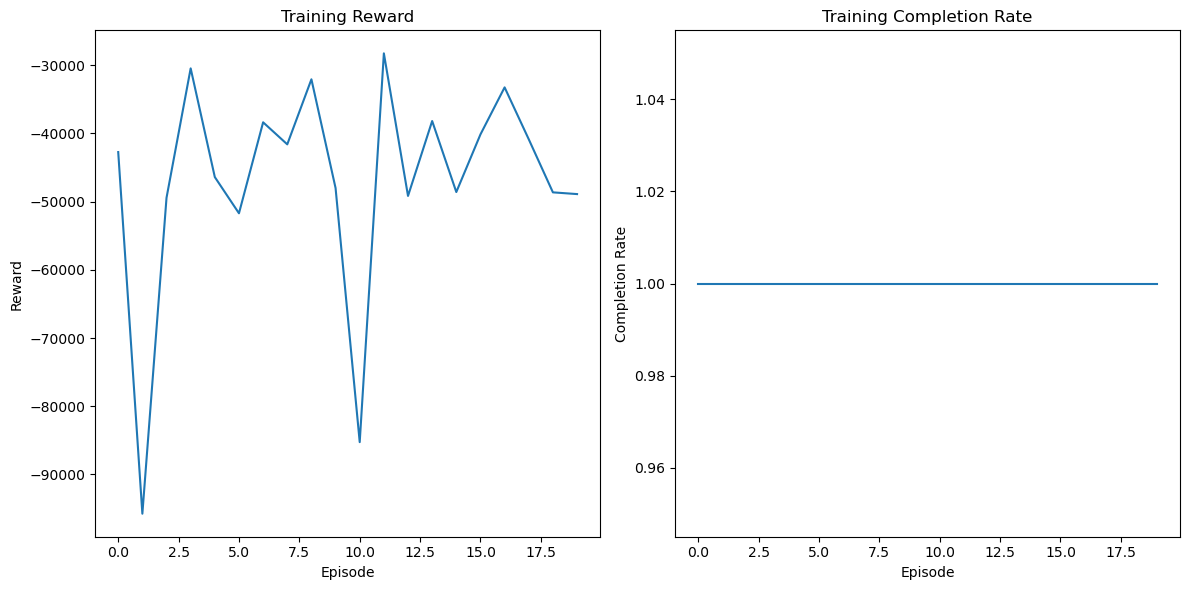

In [4]:
import matplotlib.pyplot as plt
# 多次测试以评估性能
test_episodes = 10
test_rewards = []
test_completions = []

for episode in range(test_episodes):
    state = env.reset()
    episode_reward = 0
    done = False
    steps = 0
    
    while not done and steps < hyperparams['max_steps_per_episode']:
        # 使用评估模式选择动作
        action = agent.select_action(state, evaluate=True)
        state, reward, done, info = env.step(action)
        episode_reward += reward
        steps += 1
    
    test_rewards.append(episode_reward)
    test_completions.append(info.get('completed', False))
    
    print(f"测试回合 {episode+1}: 奖励 = {episode_reward:.2f}, 完成 = {'是' if info.get('completed', False) else '否'}, 步数 = {steps}")

# 输出测试结果统计
print("\n测试结果统计:")
print(f"平均奖励: {np.mean(test_rewards):.2f} ± {np.std(test_rewards):.2f}")
print(f"完成率: {np.mean(test_completions)*100:.2f}%")

# 保存模型
# import torch
# torch.save(agent.actor.state_dict(), 'best_td3_actor.pth')
# torch.save(agent.critic_1.state_dict(), 'best_td3_critic1.pth')
# torch.save(agent.critic_2.state_dict(), 'best_td3_critic2.pth')
# print("\n模型已保存为 best_td3_actor.pth, best_td3_critic1.pth, best_td3_critic2.pth")

# 绘制训练过程中的奖励变化
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(episode_rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Training Reward')

plt.subplot(1, 2, 2)
plt.plot(completion_rates)
plt.xlabel('Episode')
plt.ylabel('Completion Rate')
plt.title('Training Completion Rate')

plt.tight_layout()
plt.show()

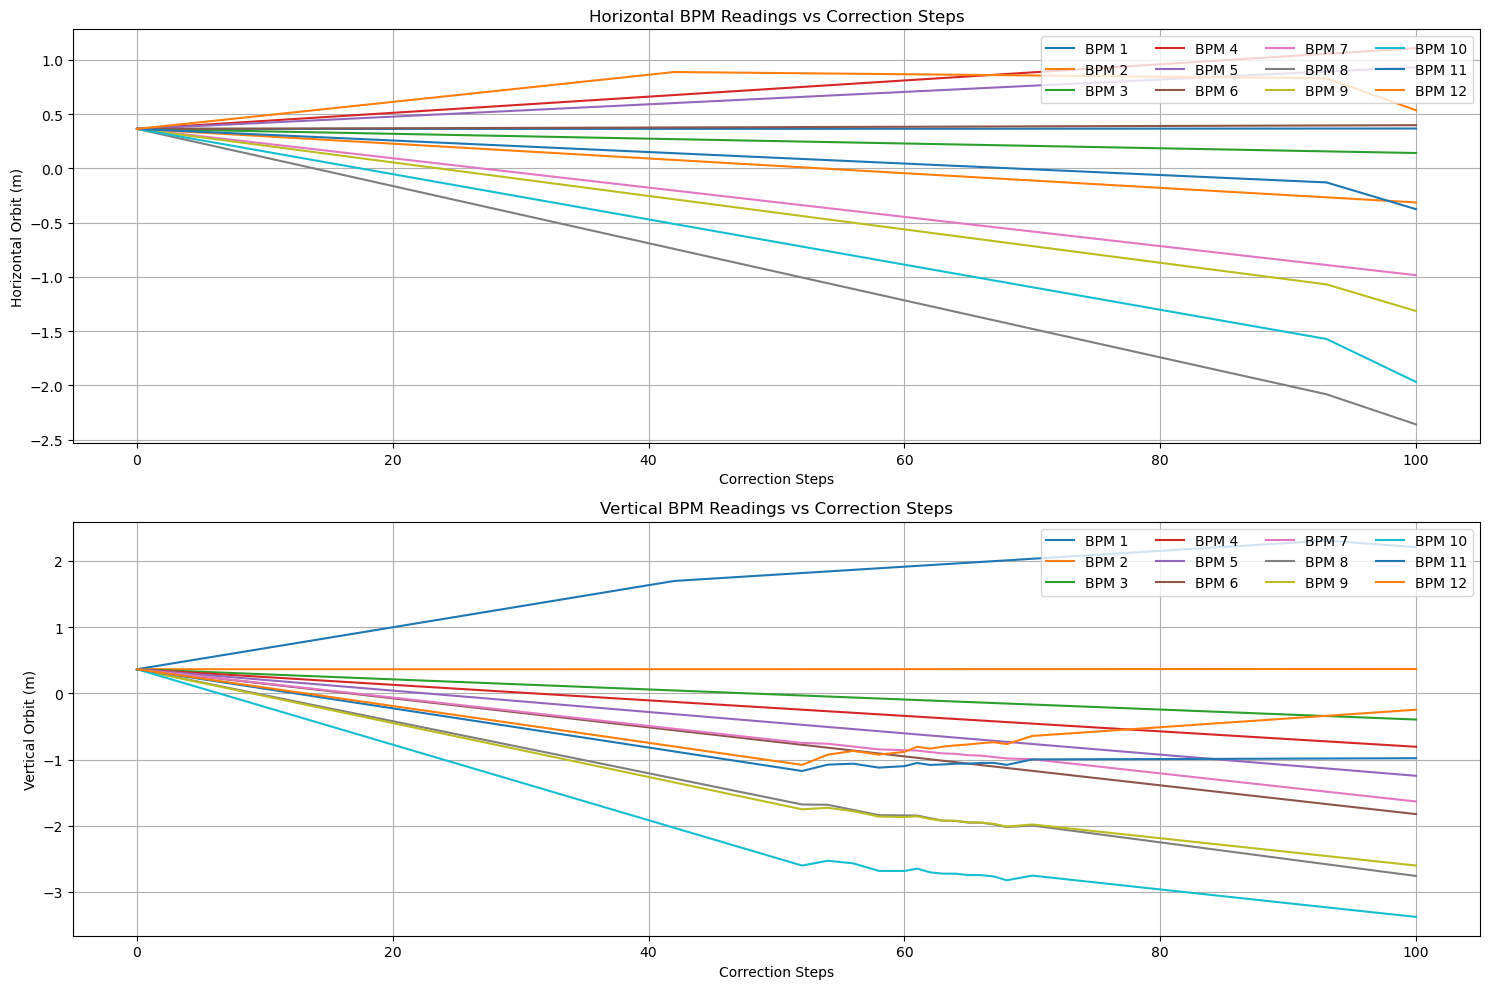

Initial horizontal orbit error: 3.63e-01 m
Final horizontal orbit error: 9.00e-01 m
Initial vertical orbit error: 3.63e-01 m
Final vertical orbit error: 1.54e+00 m
Horizontal improvement ratio: 0.40x
Vertical improvement ratio: 0.24x


In [5]:
# 分析校正前后的轨道差异
def analyze_correction_effect(env, agent):
    # 获取初始轨道
    initial_state = env.reset()
    initial_orbit_x = initial_state[:12]  # 前12个元素是水平BPM读数
    initial_orbit_y = initial_state[12:24]  # 接下来12个元素是垂直BPM读数
    
    # 运行100次校正过程
    state = initial_state.copy()
    orbit_history_x = [initial_orbit_x.copy()]
    orbit_history_y = [initial_orbit_y.copy()]
    
    for step in range(100):  # 执行100步校正
        action = agent.select_action(state, evaluate=True)
        state, reward, done, info = env.step(action)
        current_orbit_x = state[:12]
        current_orbit_y = state[12:24]
        orbit_history_x.append(current_orbit_x.copy())
        orbit_history_y.append(current_orbit_y.copy())
        
        # 不检查done，继续执行100步
    
    # 转换为numpy数组便于分析
    orbit_history_x = np.array(orbit_history_x)
    orbit_history_y = np.array(orbit_history_y)
    
    # 绘制轨道变化
    plt.figure(figsize=(15, 10))
    
    # 水平轨道
    plt.subplot(2, 1, 1)
    for i in range(12):
        plt.plot(orbit_history_x[:, i], label=f'BPM {i+1}')
    plt.xlabel('Correction Steps')
    plt.ylabel('Horizontal Orbit (m)')
    plt.title('Horizontal BPM Readings vs Correction Steps')
    plt.grid(True)
    plt.legend(loc='upper right', ncol=4)
    
    # 垂直轨道
    plt.subplot(2, 1, 2)
    for i in range(12):
        plt.plot(orbit_history_y[:, i], label=f'BPM {i+1}')
    plt.xlabel('Correction Steps')
    plt.ylabel('Vertical Orbit (m)')
    plt.title('Vertical BPM Readings vs Correction Steps')
    plt.grid(True)
    plt.legend(loc='upper right', ncol=4)
    
    plt.tight_layout()
    plt.show()
    
    # 打印统计信息
    print(f"Initial horizontal orbit error: {np.mean(np.abs(initial_orbit_x)):.2e} m")
    print(f"Final horizontal orbit error: {np.mean(np.abs(orbit_history_x[-1])):.2e} m")
    print(f"Initial vertical orbit error: {np.mean(np.abs(initial_orbit_y)):.2e} m")
    print(f"Final vertical orbit error: {np.mean(np.abs(orbit_history_y[-1])):.2e} m")
    
    if np.mean(np.abs(orbit_history_x[-1])) > 0:
        h_improvement = np.mean(np.abs(initial_orbit_x))/np.mean(np.abs(orbit_history_x[-1]))
        print(f"Horizontal improvement ratio: {h_improvement:.2f}x")
    
    if np.mean(np.abs(orbit_history_y[-1])) > 0:
        v_improvement = np.mean(np.abs(initial_orbit_y))/np.mean(np.abs(orbit_history_y[-1]))
        print(f"Vertical improvement ratio: {v_improvement:.2f}x")

# 运行分析
analyze_correction_effect(env, agent)